In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import yfinance as yf

In [2]:
# Data Collection
data = yf.download('BTC-USD', start='2023-01-01', end='2023-11-15')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Using multiple features


[*********************100%***********************]  1 of 1 completed


In [3]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [31]:
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])  # All features
        Y.append(dataset[i + time_step, 3])  # 'Close' is at index 3
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(scaled_data, time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 5)  # Reshape for LSTM


<function create_dataset at 0x000001ECDC908040>


In [5]:
# Model Building
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 5)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))


In [6]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [7]:
# Training
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.1)

Epoch 1/100
8/8 [==============================] - 4s 177ms/step - loss: 0.0781 - val_loss: 0.0294
Epoch 2/100
8/8 [==============================] - 0s 39ms/step - loss: 0.0178 - val_loss: 0.1041
Epoch 3/100
8/8 [==============================] - 0s 50ms/step - loss: 0.0088 - val_loss: 0.0268
Epoch 4/100
8/8 [==============================] - 0s 38ms/step - loss: 0.0095 - val_loss: 0.0662
Epoch 5/100
8/8 [==============================] - 0s 47ms/step - loss: 0.0091 - val_loss: 0.0592
Epoch 6/100
8/8 [==============================] - 0s 57ms/step - loss: 0.0079 - val_loss: 0.0466
Epoch 7/100
8/8 [==============================] - 0s 38ms/step - loss: 0.0073 - val_loss: 0.0575
Epoch 8/100
8/8 [==============================] - 0s 39ms/step - loss: 0.0079 - val_loss: 0.0433
Epoch 9/100
8/8 [==============================] - 0s 38ms/step - loss: 0.0071 - val_loss: 0.0519
Epoch 10/100
8/8 [==============================] - 0s 36ms/step - loss: 0.0072 - val_loss: 0.0525
Epoch 11/100
8/8 [

Epoch 84/100
8/8 [==============================] - 0s 40ms/step - loss: 0.0027 - val_loss: 0.0096
Epoch 85/100
8/8 [==============================] - 0s 36ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 86/100
8/8 [==============================] - 0s 38ms/step - loss: 0.0031 - val_loss: 0.0062
Epoch 87/100
8/8 [==============================] - 0s 40ms/step - loss: 0.0026 - val_loss: 0.0129
Epoch 88/100
8/8 [==============================] - 0s 45ms/step - loss: 0.0029 - val_loss: 0.0112
Epoch 89/100
8/8 [==============================] - 0s 38ms/step - loss: 0.0027 - val_loss: 0.0068
Epoch 90/100
8/8 [==============================] - 0s 41ms/step - loss: 0.0028 - val_loss: 0.0067
Epoch 91/100
8/8 [==============================] - 0s 41ms/step - loss: 0.0029 - val_loss: 0.0174
Epoch 92/100
8/8 [==============================] - 0s 35ms/step - loss: 0.0033 - val_loss: 0.0136
Epoch 93/100
8/8 [==============================] - 0s 39ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 94/1

In [8]:
# Predict the next day
last_sequence = scaled_data[-time_step:]
last_sequence = last_sequence.reshape(1, time_step, 5)
next_day_prediction = model.predict(last_sequence)
predicted_close_price = scaler.inverse_transform(np.concatenate((next_day_prediction, np.zeros((1, 4))), axis=1))[:, 0]

1/1 [==============================] - 1s 697ms/step


In [9]:
# Print the predicted price
print("Predicted Next Day Price:", predicted_close_price)

Predicted Next Day Price: [35294.70062247]


In [10]:
# Add the predicted price to the DataFrame
next_day = data.index[-1] + pd.Timedelta(days=1)
data.loc[next_day] = [np.nan, np.nan, np.nan, predicted_close_price, np.nan]  # Insert NaNs for other columns


C:\Users\64724\AppData\Local\Temp\ipykernel_32792\2199200854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[next_day] = [np.nan, np.nan, np.nan, predicted_close_price, np.nan]  # Insert NaNs for other columns


C:\Users\64724\AppData\Local\Temp\ipykernel_32792\4251320916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = pd.to_numeric(data['Close'], errors='coerce')


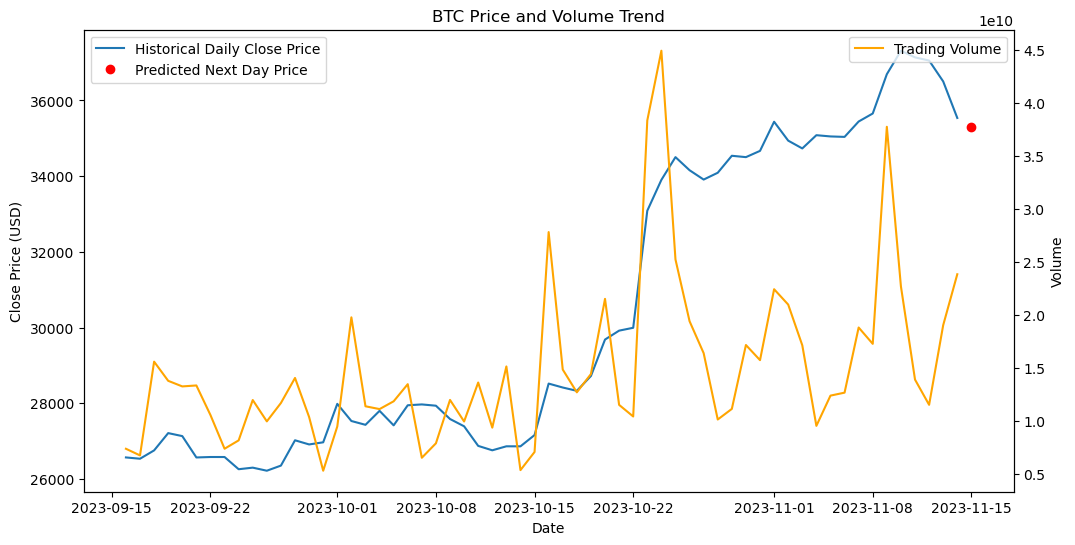

In [36]:
# Plot the last part of the data and the prediction
# Convert 'Close' column to numeric
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Create a figure and a set of subplots
plt.figure(figsize=(12, 6))

# First y-axis for 'Close' price
ax1 = plt.gca()  # Get current axes
ax1.plot(data['Close'].dropna()[-time_step:], label='Historical Daily Close Price')  # Drop NaN values
ax1.plot(next_day, predicted_close_price, 'ro', label='Predicted Next Day Price')
ax1.set_title('BTC Price and Volume Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price (USD)')
ax1.legend(loc='upper left')

# Second y-axis for 'Volume'
ax2 = ax1.twinx()  # Create another axes that shares the same x-axis
ax2.plot(data['Volume'].dropna()[-time_step:], label='Trading Volume', color='orange')
ax2.set_ylabel('Volume')
ax2.legend(loc='upper right')

plt.show()


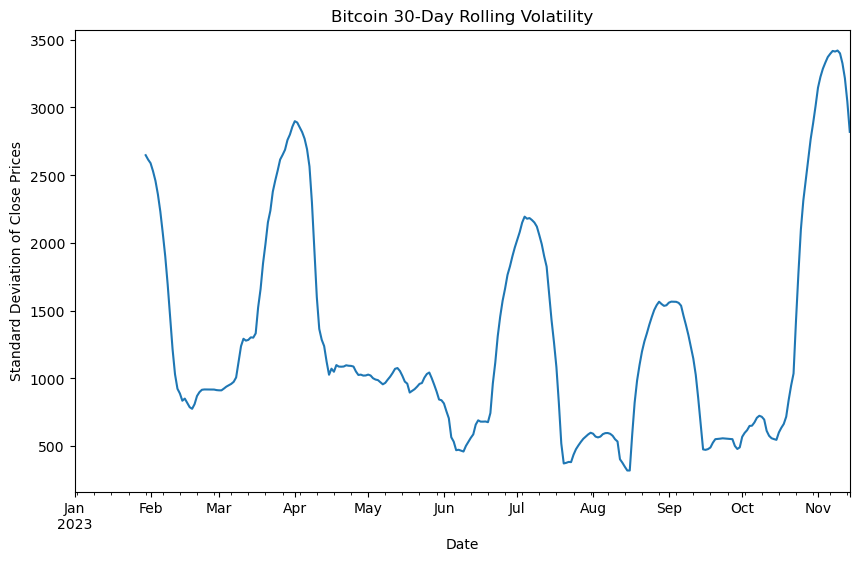

In [13]:
# EDA: Volatility Analysis
data['Close'].dropna().rolling(window=30).std().plot(figsize=(10, 6), title='Bitcoin 30-Day Rolling Volatility')  # Drop NaN values
plt.xlabel('Date')
plt.ylabel('Standard Deviation of Close Prices')
plt.show()

Median (50th percentile): 15202123792.0
First quartile (25th percentile): 11688012747.0
Third quartile (75th percentile): 21530417084.0
Interquartile Range (IQR): 9842404337.0
Lower Whisker: -3075593758.5
Upper Whisker: 36294023589.5
Outliers:
Date
2023-01-14    3.896778e+10
2023-02-16    3.931666e+10
2023-02-17    4.135845e+10
2023-03-10    3.957826e+10
2023-03-13    4.946636e+10
2023-03-14    5.462223e+10
2023-03-15    4.365570e+10
2023-03-17    5.073026e+10
2023-03-19    3.776945e+10
2023-03-20    4.477403e+10
2023-10-23    3.836357e+10
2023-10-24    4.493500e+10
2023-11-09    3.776267e+10
Name: Volume, dtype: float64


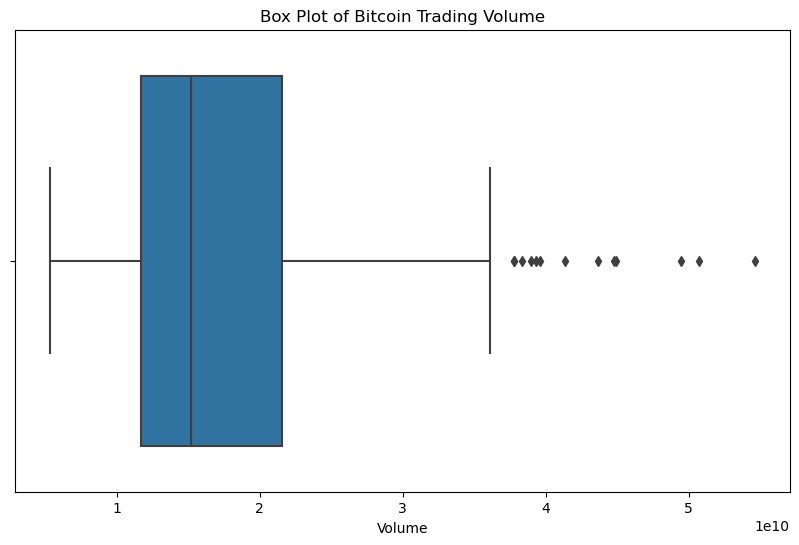

In [41]:
quartiles = data['Volume'].quantile([0.25, 0.5, 0.75])
iqr = quartiles[0.75] - quartiles[0.25]
lower_whisker = quartiles[0.25] - 1.5 * iqr
upper_whisker = quartiles[0.75] + 1.5 * iqr

print(f"Median (50th percentile): {quartiles[0.5]}")
print(f"First quartile (25th percentile): {quartiles[0.25]}")
print(f"Third quartile (75th percentile): {quartiles[0.75]}")
print(f"Interquartile Range (IQR): {iqr}")
print(f"Lower Whisker: {lower_whisker}")
print(f"Upper Whisker: {upper_whisker}")

# Detecting outliers
outliers = data['Volume'][(data['Volume'] < lower_whisker) | (data['Volume'] > upper_whisker)]
print(f"Outliers:\n{outliers}")

# Assuming data['Volume'] is already in a proper numeric format
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['Volume'])
plt.title('Box Plot of Bitcoin Trading Volume')
plt.xlabel('Volume')
plt.show()

In [42]:
# # EDA: Time Series Decomposition Plots
# decomposition = seasonal_decompose(data['Close'].dropna(), model='additive', period=30)  # Drop NaN values
# fig = decomposition.plot()
# fig.set_size_inches(10, 8)
# fig.suptitle('Time Series Decomposition of Bitcoin Closing Price')
# plt.show()

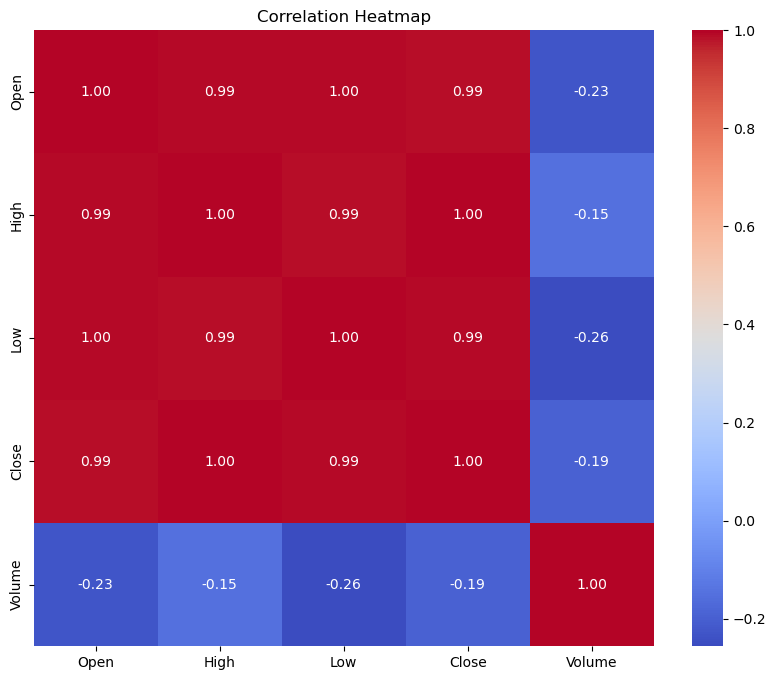

In [15]:
# EDA: Correlation Heatmaps
plt.figure(figsize=(10, 8))
sns.heatmap(data.dropna().corr(), annot=True, cmap='coolwarm', fmt=".2f")  # Drop NaN values
plt.title('Correlation Heatmap')
plt.show()


In [16]:
# Model Selection and Development
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [17]:
# Preparing data for additional models
X = scaled_data[:, :-1]  # All features except the target
y = scaled_data[:, 3]   # 'Close' price as the target

In [18]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [19]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)


In [20]:
# Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)


In [21]:
# Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500)
nn_model.fit(X_train, y_train)
nn_predictions = nn_model.predict(X_test)

In [22]:
# Model Evaluation
print("Linear Regression MSE:", mean_squared_error(y_test, lr_predictions))
print("Random Forest MSE:", mean_squared_error(y_test, rf_predictions))
print("Neural Network MSE:", mean_squared_error(y_test, nn_predictions))

Linear Regression MSE: 2.4074124304840448e-33
Random Forest MSE: 0.014015155916544527
Neural Network MSE: 0.00013781989051281487


In [23]:
# Model Evaluation and Refinement: Cross-Validation, Hyperparameter Tuning (Example for Random Forest)
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {'n_estimators': [100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20]}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=tscv, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters for Random Forest:", grid_search.best_params_)

C:\Users\64724\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Parameters for Random Forest: {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}


In [24]:
# Calculate the 10-day Simple Moving Average
data['SMA_10'] = data['Close'].rolling(window=10).mean()


C:\Users\64724\AppData\Local\Temp\ipykernel_32792\3339775392.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SMA_10'] = data['Close'].rolling(window=10).mean()


In [61]:
# Define trading signals
data['strategy_signal'] = 0  # Default to no position
data['strategy_signal'][data['Close'] > data['SMA_10']] = 1  # Buy signal
data['strategy_signal'][data['Close'] < data['SMA_10']] = -1  # Sell signal


C:\Users\64724\AppData\Local\Temp\ipykernel_32792\2789256201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['strategy_signal'] = 0  # Default to no position
C:\Users\64724\AppData\Local\Temp\ipykernel_32792\2789256201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['strategy_signal'][data['Close'] > data['SMA_10']] = 1  # Buy signal
C:\Users\64724\AppData\Local\Temp\ipykernel_32792\2789256201.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

In [62]:
# Calculate daily returns
data['strategy_return'] = data['strategy_signal'].shift(1) * data['Close'].pct_change()

C:\Users\64724\AppData\Local\Temp\ipykernel_32792\3782777882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['strategy_return'] = data['strategy_signal'].shift(1) * data['Close'].pct_change()


In [63]:
# Calculate cumulative returns
data['cumulative_strategy_return'] = (1 + data['strategy_return']).cumprod()
data['cumulative_market_return'] = (1 + data['Close'].pct_change()).cumprod()

C:\Users\64724\AppData\Local\Temp\ipykernel_32792\1997598318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cumulative_strategy_return'] = (1 + data['strategy_return']).cumprod()
C:\Users\64724\AppData\Local\Temp\ipykernel_32792\1997598318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cumulative_market_return'] = (1 + data['Close'].pct_change()).cumprod()


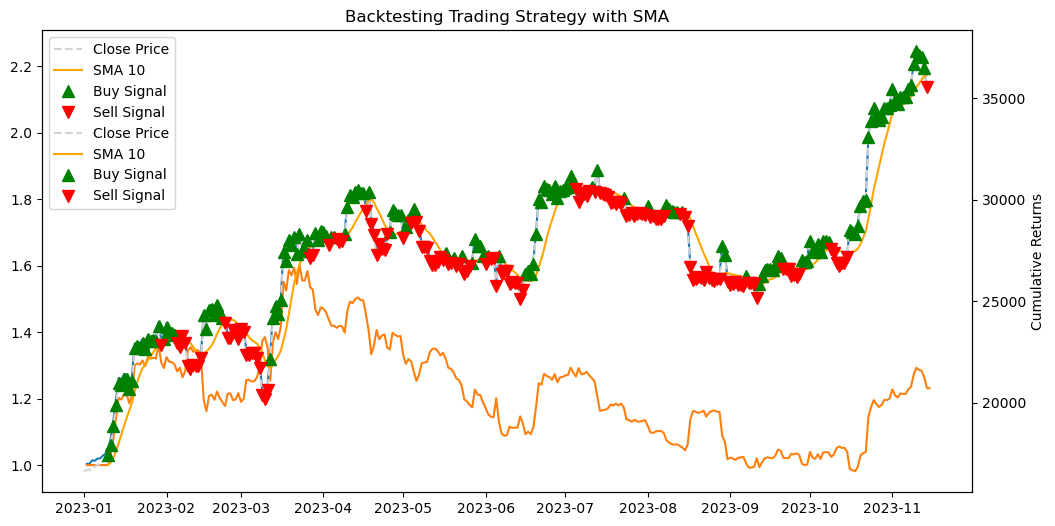

In [64]:
plt.figure(figsize=(12, 6))

# Plotting the market and strategy cumulative returns
plt.plot(data['cumulative_market_return'], label='Market Returns (Buy and Hold)')
plt.plot(data['cumulative_strategy_return'], label='Strategy Returns')

# Setting up a secondary y-axis for SMA
ax2 = plt.gca().twinx()
ax2.plot(data['Close'], color='lightgray', linestyle='--', label='Close Price')
ax2.plot(data['SMA_10'], color='orange', linestyle='-', label='SMA 10')
ax2.set_ylabel('Close Price and SMA 10')

# Marking trade points
# Buy signals: Close < SMA_10, Sell signals: Close > SMA_10
buy_signals = data['Close'] > data['SMA_10']
sell_signals = data['Close'] < data['SMA_10']

ax2.plot(data[buy_signals].index, data['Close'][buy_signals], 'g^', label='Buy Signal', markersize=8)  # Green triangles for buy
ax2.plot(data[sell_signals].index, data['Close'][sell_signals], 'rv', label='Sell Signal', markersize=8)  # Red triangles for sell

# Adding legends
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Setting titles and labels
plt.title('Backtesting Trading Strategy with SMA')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')

plt.show()


In [65]:
# Performance Metrics
total_strategy_return = data['cumulative_strategy_return'].iloc[-1] - 1
total_market_return = data['cumulative_market_return'].iloc[-1] - 1
print(f"Total Strategy Return: {total_strategy_return:.2f}")
print(f"Total Market Return: {total_market_return:.2f}")


Total Strategy Return: 0.23
Total Market Return: 1.14
